In [11]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import mstats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import xgboost as xgb

import warnings as w
w.filterwarnings('ignore')

In [3]:
# Load dataset
data = pd.read_csv('Lung Cancer Dataset.csv')

# Clean column names (optional: remove spaces, make uppercase)
data.columns = data.columns.str.strip().str.upper()

# View first few rows
print(data.sample(5))

            ID  AGE  GENDER         COUNTRY DIAGNOSIS_DATE CANCER_STAGE  \
850531  850532   58    Male           Italy     21-12-2022    Stage III   
460982  460983   66    Male         Belgium     27-10-2022     Stage IV   
70077    70078   50  Female  Czech Republic     29-04-2023    Stage III   
636146  636147   55  Female         Germany     21-04-2021      Stage I   
966724  966725   48    Male         Hungary     30-05-2020          NaN   

       FAMILY_HISTORY  SMOKING_STATUS   BMI  CHOLESTEROL_LEVEL  HYPERTENSION  \
850531            Yes   Former Smoker  35.2                278             1   
460982            Yes   Former Smoker  44.6                278             1   
70077             Yes  Passive Smoker  41.0                251             1   
636146            Yes   Former Smoker  38.6                293             0   
966724             No  Passive Smoker  41.6                180             1   

        ASTHMA  CIRRHOSIS  OTHER_CANCER TREATMENT_TYPE END_TREATMENT

In [6]:
data.shape

(1000000, 18)

In [7]:
# Summary statistics
print(data.describe())

                   ID             AGE             BMI  CHOLESTEROL_LEVEL  \
count  1000000.000000  1000000.000000  1000000.000000     1000000.000000   
mean    500000.500000       55.012166       30.497631         233.622222   
std     288675.278933        9.994536        8.335382          43.407898   
min          1.000000        4.000000       15.000000         100.000000   
25%     250000.750000       48.000000       23.400000         197.000000   
50%     500000.500000       55.000000       30.500000         241.000000   
75%     750000.250000       62.000000       37.500000         270.000000   
max    1000000.000000      104.000000       50.000000         350.000000   

         HYPERTENSION          ASTHMA       CIRRHOSIS    OTHER_CANCER  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.700754        0.440179        0.206749        0.089407   
std          0.457928        0.496409        0.404974        0.285330   
min          0.000000  

In [5]:
# all column names
data.columns

Index(['ID', 'AGE', 'GENDER', 'COUNTRY', 'DIAGNOSIS_DATE', 'CANCER_STAGE',
       'FAMILY_HISTORY', 'SMOKING_STATUS', 'BMI', 'CHOLESTEROL_LEVEL',
       'HYPERTENSION', 'ASTHMA', 'CIRRHOSIS', 'OTHER_CANCER', 'TREATMENT_TYPE',
       'END_TREATMENT_DATE', 'SURVIVED', 'LUNG_CANCER'],
      dtype='object')

In [4]:
# Check data info
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ID                  1000000 non-null  int64  
 1   AGE                 1000000 non-null  int64  
 2   GENDER              1000000 non-null  object 
 3   COUNTRY             1000000 non-null  object 
 4   DIAGNOSIS_DATE      1000000 non-null  object 
 5   CANCER_STAGE        890000 non-null   object 
 6   FAMILY_HISTORY      1000000 non-null  object 
 7   SMOKING_STATUS      1000000 non-null  object 
 8   BMI                 1000000 non-null  float64
 9   CHOLESTEROL_LEVEL   1000000 non-null  int64  
 10  HYPERTENSION        1000000 non-null  int64  
 11  ASTHMA              1000000 non-null  int64  
 12  CIRRHOSIS           1000000 non-null  int64  
 13  OTHER_CANCER        1000000 non-null  int64  
 14  TREATMENT_TYPE      890000 non-null   object 
 15  END_TREATMENT_DA

In [7]:
data["LUNG_CANCER"].nunique()

2

In [5]:
# ---------------------------------------------
# Step 2: Data Preprocessing (Clean Version)
# ---------------------------------------------

# Map cancer stages (categorical) to integers
stage_mapping = {
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 4
}

# Create a new numeric column for cancer stage
data['CANCER_STAGE_INT'] = data['CANCER_STAGE'].map(stage_mapping)


#changing the datatype of different column holding wrong datatypes
data['DIAGNOSIS_DATE']=pd.to_datetime(data['DIAGNOSIS_DATE'], format = "%d-%m-%Y")
data['END_TREATMENT_DATE']=pd.to_datetime(data['END_TREATMENT_DATE'],format = "%d-%m-%Y")
# Calculate number of days between diagnosis and end of treatment
data['TREATMENT_DURATION_DAYS'] = (data['END_TREATMENT_DATE'] - data['DIAGNOSIS_DATE']).dt.days

# Extract year, month, or day from DIAGNOSIS_DATE
data['DIAGNOSIS_YEAR'] = data['DIAGNOSIS_DATE'].dt.year
data['DIAGNOSIS_MONTH'] = data['DIAGNOSIS_DATE'].dt.month
data['DIAGNOSIS_DAY'] = data['DIAGNOSIS_DATE'].dt.day

# Drop the original DIAGNOSIS_DATE column
data.drop('DIAGNOSIS_DATE', axis=1, inplace=True)

# Here we assume that if there's any stage, it's a cancer case
#data['LUNG_CANCER'] = data['CANCER_STAGE_INT'].apply(lambda x: 1 if x != 0 else 0)

data['FAMILY_HISTORY_INT'] = data['FAMILY_HISTORY'].apply(lambda x: 1 if x == 'Yes' else 0)

In [6]:
#dropping unnecessary columns
df = data.drop('ID',axis=1)
df.sample()

,AGE,GENDER,COUNTRY,CANCER_STAGE,FAMILY_HISTORY,SMOKING_STATUS,BMI,CHOLESTEROL_LEVEL,HYPERTENSION,ASTHMA,...,TREATMENT_TYPE,END_TREATMENT_DATE,SURVIVED,LUNG_CANCER,CANCER_STAGE_INT,TREATMENT_DURATION_DAYS,DIAGNOSIS_YEAR,DIAGNOSIS_MONTH,DIAGNOSIS_DAY,FAMILY_HISTORY_INT
380673,55,Male,Croatia,Stage IV,No,Never Smoked,25.9,239,0,1,...,Radiation,2019-03-15,1,1,4.0,410.0,2018,1,29,0


## Exploratory Data Analysis

### What is the age distribution of lung cancer patients?

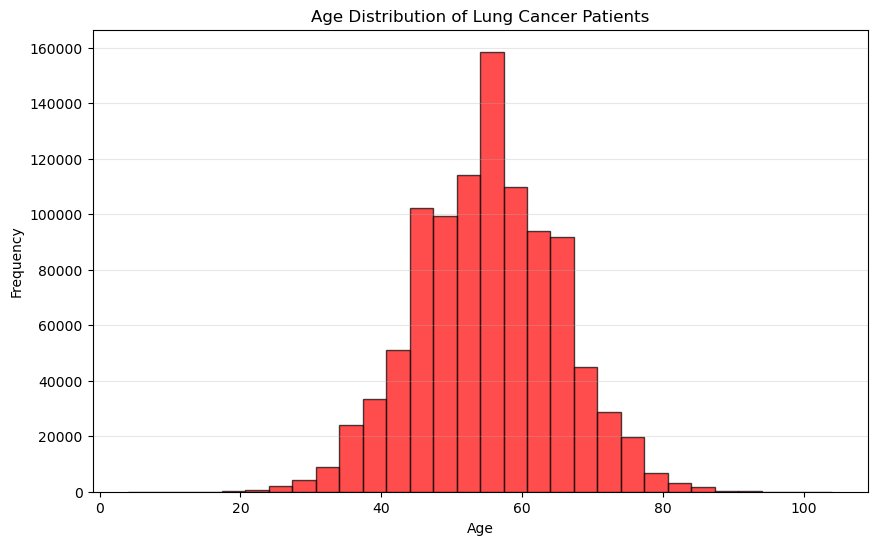

Mean age: 55.01
Median age: 55.00
Age range: 4 - 104


In [12]:
# Age distribution analysis
plt.figure(figsize=(10, 6))
plt.hist(df['AGE'], bins=30, edgecolor='black', alpha=0.7, color='red')
plt.title('Age Distribution of Lung Cancer Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Statistical summary
print(f"Mean age: {df['AGE'].mean():.2f}")
print(f"Median age: {df['AGE'].median():.2f}")
print(f"Age range: {df['AGE'].min():.0f} - {df['AGE'].max():.0f}")

*Insight*: Most lung cancer patients are middle-aged (55 mean age), with distribution skewing slightly toward older adults in 45-65 range.

### How are patients distributed across different countries?

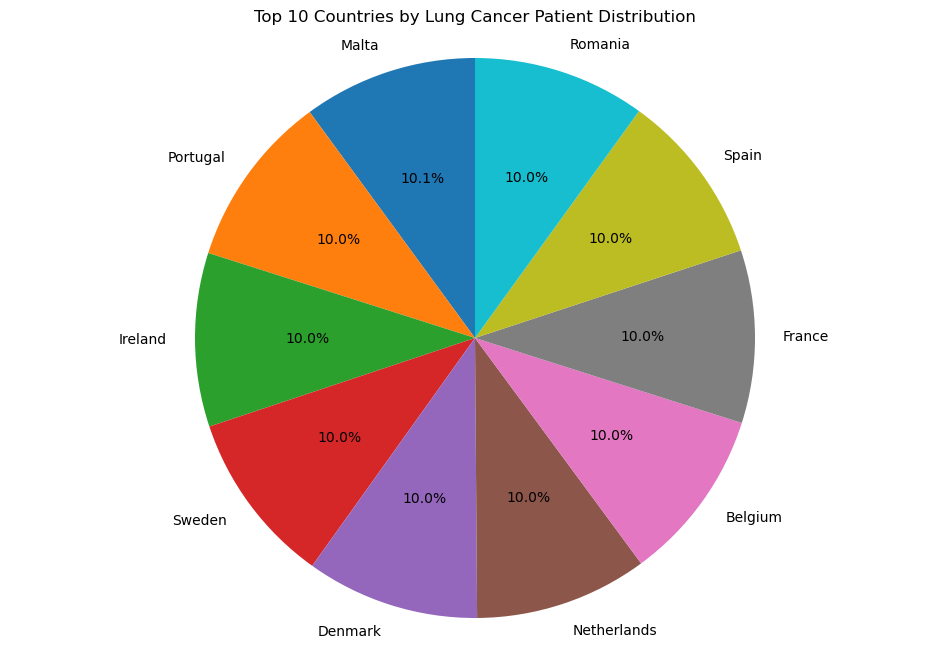

Top 10 countries:
COUNTRY
Malta          37420
Portugal       37351
Ireland        37346
Sweden         37225
Denmark        37201
Netherlands    37178
Belgium        37155
France         37131
Spain          37105
Romania        37080
Name: count, dtype: int64


In [13]:
# Country distribution pie chart
country_counts = df['COUNTRY'].value_counts().head(10)

plt.figure(figsize=(12, 8))
plt.pie(country_counts.values, labels=country_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Countries by Lung Cancer Patient Distribution')
plt.axis('equal')
plt.show()

print("Top 10 countries:")
print(country_counts)

*Insight*: Malta leads patient distribution, followed by European countries, suggesting dataset geographic bias toward smaller European nations

### What is the gender distribution and survival comparison?

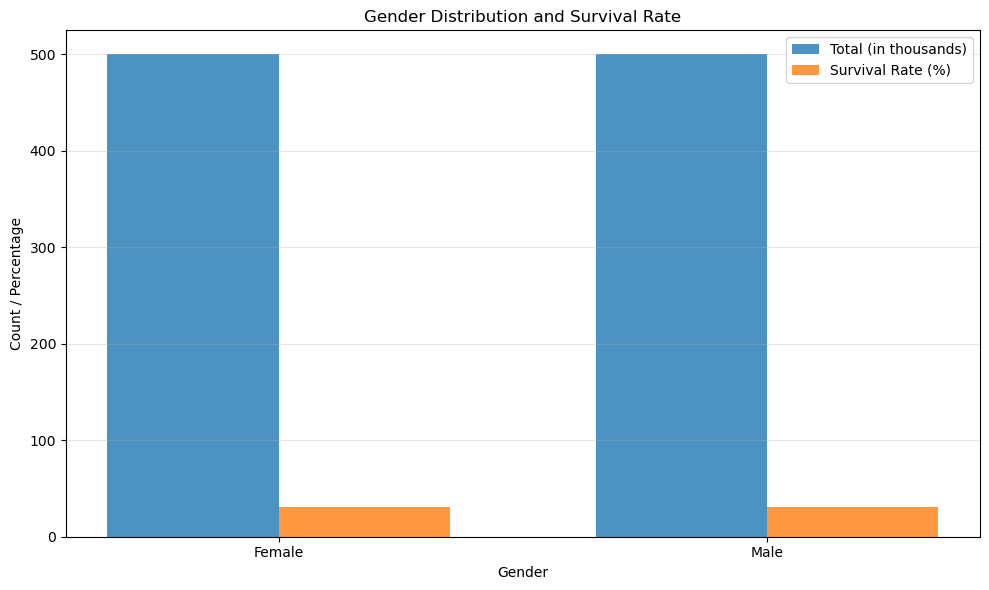

         Total  Survivors  Survival_Rate
GENDER                                  
Female  499982     152948           30.6
Male    500018     153056           30.6


In [14]:
# Gender analysis with grouped bar chart
gender_analysis = df.groupby('GENDER').agg({
    'SURVIVED': ['count', 'sum', 'mean']
}).round(3)

gender_analysis.columns = ['Total', 'Survivors', 'Survival_Rate']
gender_analysis['Survival_Rate'] *= 100

x = np.arange(len(gender_analysis.index))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, gender_analysis['Total']/1000, width, label='Total (in thousands)', alpha=0.8)
bars2 = plt.bar(x + width/2, gender_analysis['Survival_Rate'], width, label='Survival Rate (%)', alpha=0.8)

plt.xlabel('Gender')
plt.ylabel('Count / Percentage')
plt.title('Gender Distribution and Survival Rate')
plt.xticks(x, gender_analysis.index)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(gender_analysis)


*Insight*: Gender distribution is nearly equal, with females showing slightly higher survival rates than males in lung cancer cases.

### What is the relationship between family history and cancer stage?

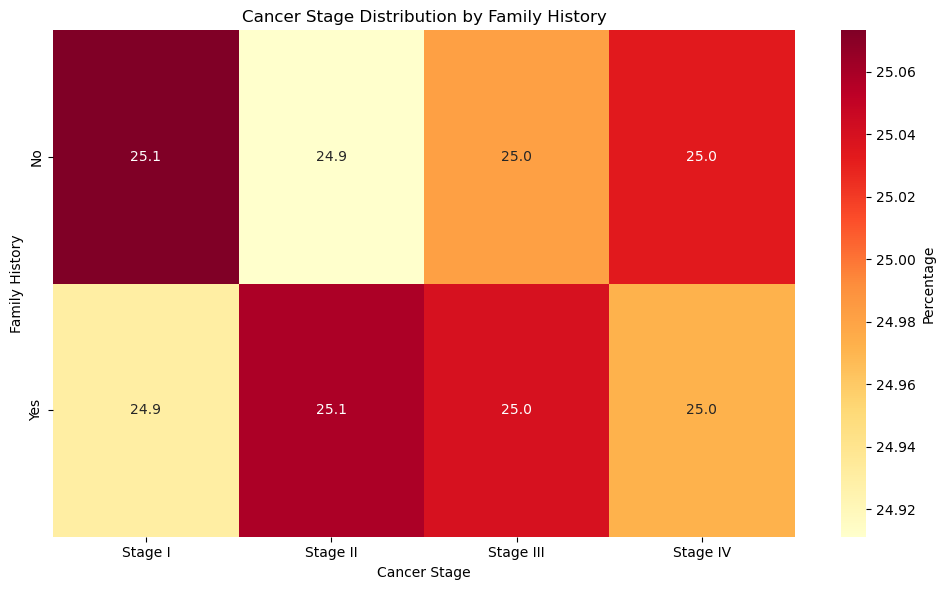

Raw counts:
CANCER_STAGE    Stage I  Stage II  Stage III  Stage IV
FAMILY_HISTORY                                        
No               111621    110900     111214    111446
Yes              110895    111463     111380    111081


In [15]:
# Family history vs cancer stage heatmap
family_stage_crosstab = pd.crosstab(df['FAMILY_HISTORY'], df['CANCER_STAGE'], normalize='index') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(family_stage_crosstab, annot=True, cmap='YlOrRd', fmt='.1f',
            cbar_kws={'label': 'Percentage'})
plt.title('Cancer Stage Distribution by Family History')
plt.xlabel('Cancer Stage')
plt.ylabel('Family History')
plt.tight_layout()
plt.show()

print("Raw counts:")
print(pd.crosstab(df['FAMILY_HISTORY'], df['CANCER_STAGE']))


*Insight*: Family history shows minimal variation in cancer stage distribution, suggesting genetic factors don't significantly influence disease progression.

### Cholesterol Level Changes by End Treatment Year

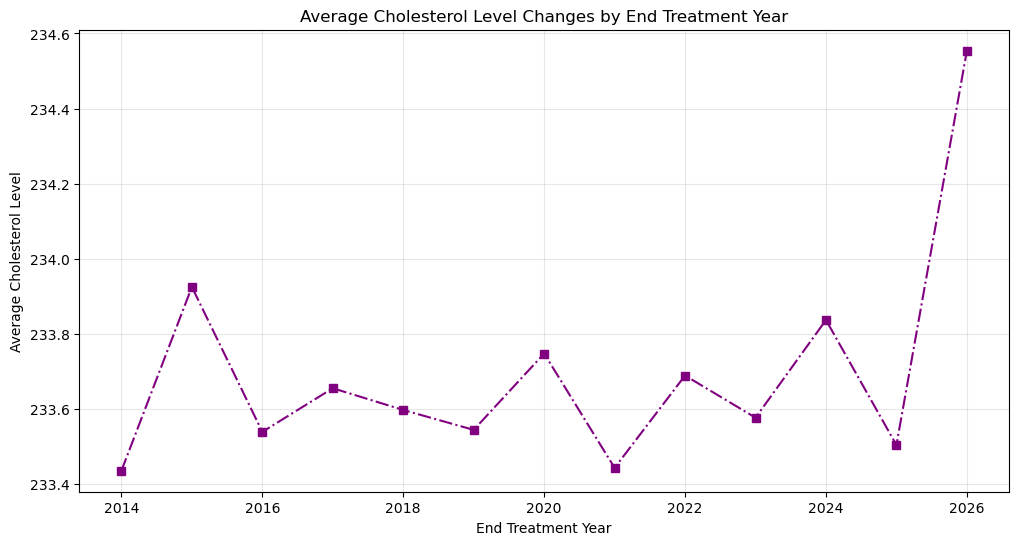

END_TREATMENT_DATE
2014.0    233.436242
2015.0    233.925380
2016.0    233.539639
2017.0    233.655792
2018.0    233.597896
2019.0    233.544948
2020.0    233.748168
2021.0    233.443908
2022.0    233.689575
2023.0    233.577391
2024.0    233.837377
2025.0    233.504514
2026.0    234.554086
Name: CHOLESTEROL_LEVEL, dtype: float64


In [16]:
end_year_chol = df.groupby(df['END_TREATMENT_DATE'].dt.year)['CHOLESTEROL_LEVEL'].mean()

plt.figure(figsize=(12, 6))
plt.plot(end_year_chol.index, end_year_chol.values, marker='s', color='purple', linestyle='-.')
plt.title('Average Cholesterol Level Changes by End Treatment Year')
plt.xlabel('End Treatment Year')
plt.ylabel('Average Cholesterol Level')
plt.grid(alpha=0.3)
plt.show()

print(end_year_chol)


*Insight*: Cholesterol levels vary inconsistently over treatment end years, with dips suggesting post-treatment health fluctuations

# **Model Train**

In [7]:
## Encode GENDER column: Male = 1, Female = 0
le = LabelEncoder()
df['GENDER'] = le.fit_transform(df['GENDER'])
df['COUNTRY'] = le.fit_transform(df['COUNTRY'])
df['SMOKING_STATUS'] = le.fit_transform(df['SMOKING_STATUS'])
df["TREATMENT_TYPE"] = le.fit_transform(df["TREATMENT_TYPE"])

In [8]:
# Drop original non-numeric or redundant columns (if still present)
df.drop(['CANCER_STAGE', 'TREATMENT_TYPE','DIAGNOSIS_DATE', 'END_TREATMENT_DATE'], axis=1, inplace=True, errors='ignore')

#Drop Family History
df.drop(columns=['CANCER_STAGE_INT','TREATMENT_DURATION_DAYS','FAMILY_HISTORY'], inplace=True)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   AGE                 1000000 non-null  int64  
 1   GENDER              1000000 non-null  int32  
 2   COUNTRY             1000000 non-null  int32  
 3   SMOKING_STATUS      1000000 non-null  int32  
 4   BMI                 1000000 non-null  float64
 5   CHOLESTEROL_LEVEL   1000000 non-null  int64  
 6   HYPERTENSION        1000000 non-null  int64  
 7   ASTHMA              1000000 non-null  int64  
 8   CIRRHOSIS           1000000 non-null  int64  
 9   OTHER_CANCER        1000000 non-null  int64  
 10  SURVIVED            1000000 non-null  int64  
 11  LUNG_CANCER         1000000 non-null  int64  
 12  DIAGNOSIS_YEAR      1000000 non-null  int32  
 13  DIAGNOSIS_MONTH     1000000 non-null  int32  
 14  DIAGNOSIS_DAY       1000000 non-null  int32  
 15  FAMILY_HISTORY_I

In [27]:
df.sample(20)

,AGE,GENDER,COUNTRY,SMOKING_STATUS,BMI,CHOLESTEROL_LEVEL,HYPERTENSION,ASTHMA,CIRRHOSIS,OTHER_CANCER,SURVIVED,LUNG_CANCER,DIAGNOSIS_YEAR,DIAGNOSIS_MONTH,DIAGNOSIS_DAY,FAMILY_HISTORY_INT
372359,61,1,2,3,37.6,283,1,0,0,0,0,1,2023,4,1,1
581936,51,1,21,0,42.4,297,1,1,0,1,1,1,2015,4,17,1
997240,60,0,11,0,32.6,164,0,0,0,0,1,0,2018,3,8,1
878821,66,0,25,3,37.9,240,1,1,0,0,0,1,2019,1,15,1
813422,50,1,7,2,18.0,236,1,1,0,0,0,1,2015,4,13,0
426921,51,0,9,0,36.2,248,0,0,0,0,0,1,2016,7,4,1
795229,56,1,17,3,19.7,230,1,1,1,0,1,1,2015,11,24,1
827800,34,1,22,3,27.3,159,0,0,0,0,0,1,2022,11,14,1
645899,76,1,18,2,41.0,253,1,1,0,0,0,1,2018,12,16,0
713689,50,0,16,2,28.4,159,0,1,0,0,0,1,2024,5,19,1


In [9]:
#Train/Test Split

# Define features and multiclass target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=20
)


In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   AGE                 1000000 non-null  int64  
 1   GENDER              1000000 non-null  int32  
 2   COUNTRY             1000000 non-null  int32  
 3   SMOKING_STATUS      1000000 non-null  int32  
 4   BMI                 1000000 non-null  float64
 5   CHOLESTEROL_LEVEL   1000000 non-null  int64  
 6   HYPERTENSION        1000000 non-null  int64  
 7   ASTHMA              1000000 non-null  int64  
 8   CIRRHOSIS           1000000 non-null  int64  
 9   OTHER_CANCER        1000000 non-null  int64  
 10  SURVIVED            1000000 non-null  int64  
 11  DIAGNOSIS_YEAR      1000000 non-null  int32  
 12  DIAGNOSIS_MONTH     1000000 non-null  int32  
 13  DIAGNOSIS_DAY       1000000 non-null  int32  
 14  FAMILY_HISTORY_INT  1000000 non-null  int64  
dtypes: float64(1), i

In [18]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import numpy as np

lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Generate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred_lr)
class_report = classification_report(y_test, y_pred_lr, output_dict=True)

print("Conf Matrix: \n")
print(conf_matrix) 
print("Report: \n")
print(class_report)

Conf Matrix: 

[[ 11851  10141]
 [  5736 172272]]
Report: 

{'0': {'precision': 0.673850002843009, 'recall': 0.538877773735904, 'f1-score': 0.5988529270572779, 'support': 21992.0}, '1': {'precision': 0.9444063745456738, 'recall': 0.9677767291357692, 'f1-score': 0.9559487377261592, 'support': 178008.0}, 'accuracy': 0.920615, 'macro avg': {'precision': 0.8091281886943413, 'recall': 0.7533272514358366, 'f1-score': 0.7774008323917185, 'support': 200000.0}, 'weighted avg': {'precision': 0.9146559959132488, 'recall': 0.920615, 'f1-score': 0.9166824823850089, 'support': 200000.0}}


In [19]:
# Random Forest

rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)


# Return confusion matrices only for preview
print(rf_report)

{'0': {'precision': 0.8540752351097178, 'recall': 0.7433157511822481, 'f1-score': 0.7948555868909851, 'support': 21992.0}, '1': {'precision': 0.9687880128276014, 'recall': 0.9843096939463395, 'f1-score': 0.9764871763433909, 'support': 178008.0}, 'accuracy': 0.95781, 'macro avg': {'precision': 0.9114316239686596, 'recall': 0.8638127225642938, 'f1-score': 0.885671381617188, 'support': 200000.0}, 'weighted avg': {'precision': 0.9561741957897429, 'recall': 0.95781, 'f1-score': 0.9565149667672043, 'support': 200000.0}}


In [37]:
# Check correlation with target again
correlation = data.corr(numeric_only=True)['LUNG_CANCER'].sort_values(ascending=False)
print(correlation.head(15))

LUNG_CANCER           1.000000
HYPERTENSION          0.306042
ASTHMA                0.169389
CIRRHOSIS             0.134907
DIAGNOSIS_DAY         0.001758
CHOLESTEROL_LEVEL     0.000766
DIAGNOSIS_MONTH       0.000548
FAMILY_HISTORY_INT   -0.000167
BMI                  -0.001181
AGE                  -0.001468
OTHER_CANCER         -0.012458
DIAGNOSIS_YEAR       -0.061951
SURVIVED             -0.529439
ID                   -0.541941
CANCER_STAGE_INT           NaN
Name: LUNG_CANCER, dtype: float64


In [10]:
corr_matrix = X_train.corr()

# Display top of the matrix just to verify
print(corr_matrix.head())

                     AGE    GENDER   COUNTRY  SMOKING_STATUS       BMI  \
AGE             1.000000 -0.000659  0.000418       -0.000530  0.001025   
GENDER         -0.000659  1.000000  0.000407       -0.000019 -0.000011   
COUNTRY         0.000418  0.000407  1.000000        0.001124  0.000075   
SMOKING_STATUS -0.000530 -0.000019  0.001124        1.000000  0.000068   
BMI             0.001025 -0.000011  0.000075        0.000068  1.000000   

                CHOLESTEROL_LEVEL  HYPERTENSION    ASTHMA  CIRRHOSIS  \
AGE                      0.002872     -0.001600 -0.001018  -0.000290   
GENDER                  -0.000254      0.000223  0.001200   0.000644   
COUNTRY                  0.000943      0.000942 -0.000199  -0.000053   
SMOKING_STATUS           0.002169     -0.000708 -0.000284   0.000752   
BMI                      0.667324      0.000985  0.000204   0.000610   

                OTHER_CANCER  SURVIVED  DIAGNOSIS_YEAR  DIAGNOSIS_MONTH  \
AGE                -0.000837  0.001672       -0

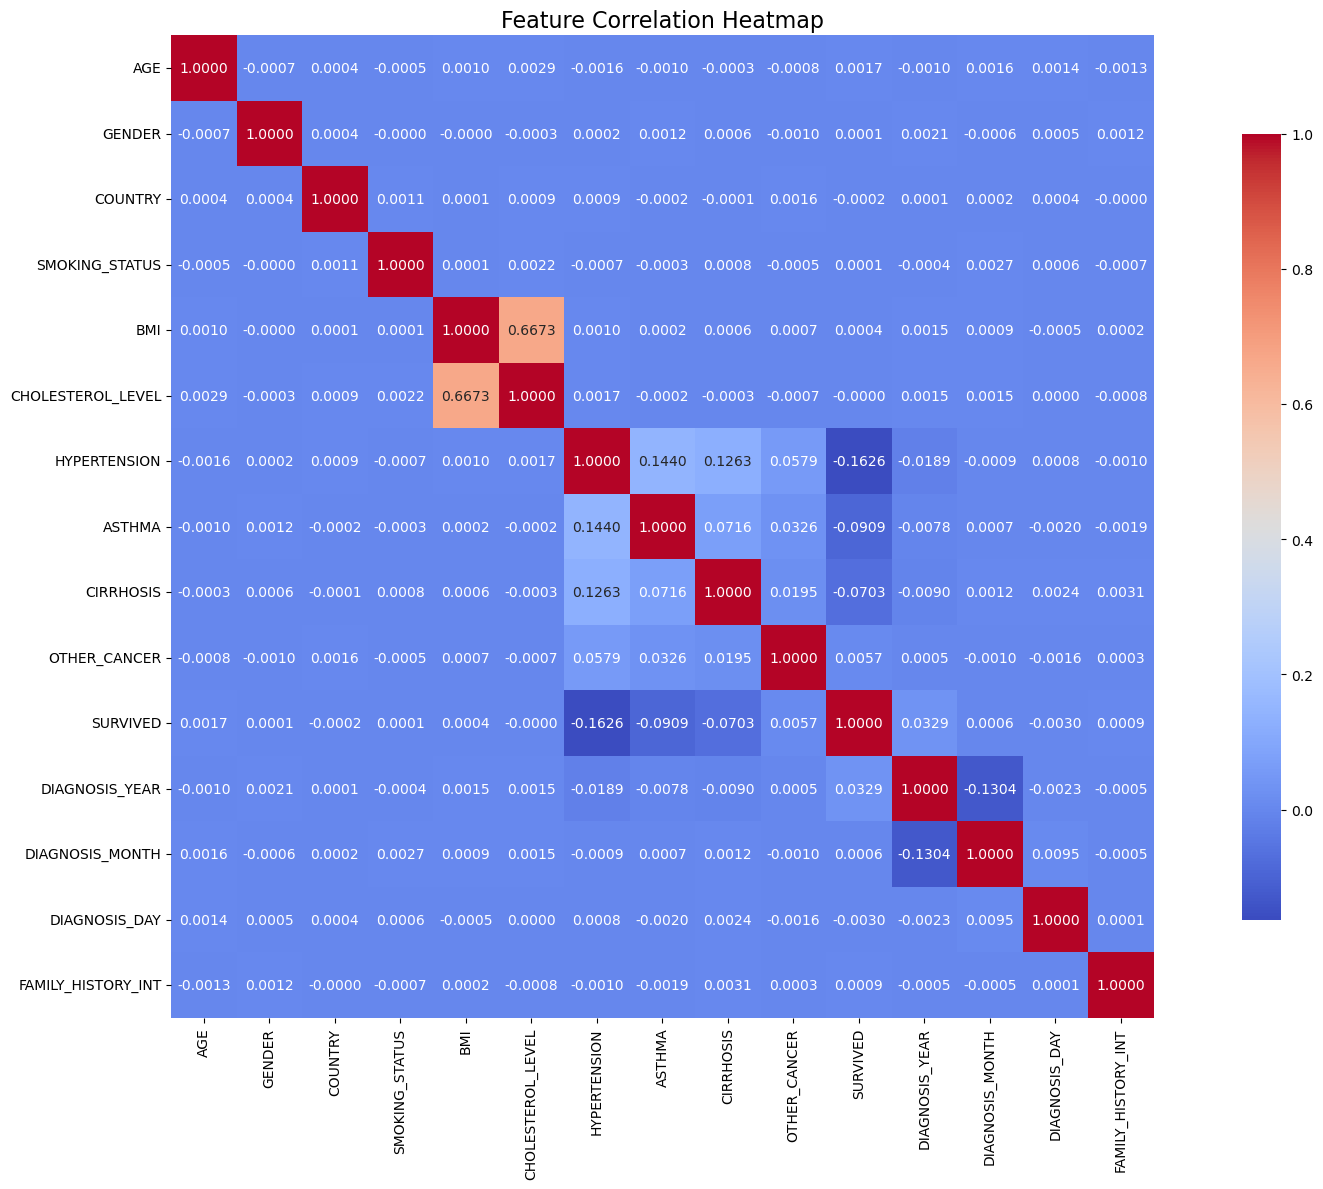

In [13]:
#HeatMap

plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix,
    annot=True,           # Show correlation values
    fmt=".4f",            # Decimal formatting
    cmap="coolwarm",      # Color theme
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


HyperTunings

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best RF Cross-Validation Score: 0.9582962504217453

Random Forest - Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.74      0.79     21992
           1       0.97      0.98      0.98    178008

    accuracy                           0.96    200000
   macro avg       0.91      0.86      0.89    200000
weighted avg       0.96      0.96      0.96    200000



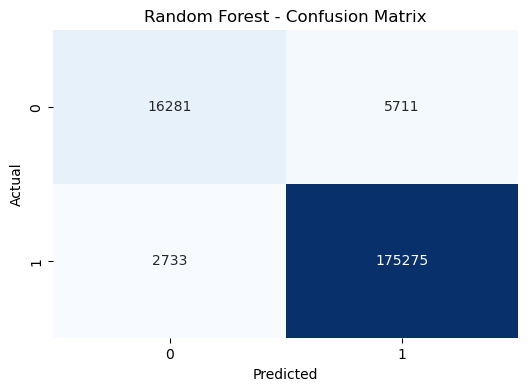

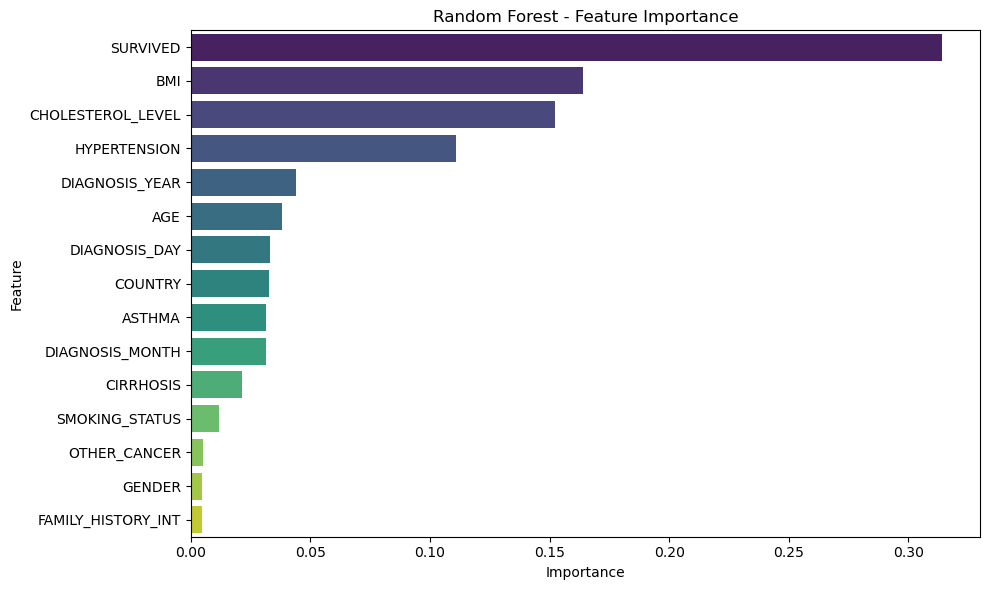

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Hyperparameter Tuning
# ------------------------------
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Random Forest Params:", grid_rf.best_params_)
print("Best RF Cross-Validation Score:", grid_rf.best_score_)

# ------------------------------
# Best Model Evaluation
# ------------------------------
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Classification Report
print("\nRandom Forest - Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.show()

# ------------------------------
# Feature Importance Plot
# ------------------------------
importances = best_rf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()